# 2021 Biomedical Data Science Hackathon
### This notebook contains data preparation and prediction processes for our participation in a data science Hackathon

The team is provided with 3 csv files containing training and testing datasets.

\#The dataset is a collection of "unnormalized counts of genes from RNASeq performed on patients"

\#A designed challenge is working with data from an unfamiliar context, and participants (w/ or w/o Biology background) are expected to have limited prior knowledge.  

The goal is to predict the age of a patient from their gene profile.

In [22]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import random as rnd

In [3]:
##load train data
df_expression = pd.read_csv(
    './train_data/train_expression.csv.gz', compression='gzip')

df_labels = pd.read_csv(
    './train_data/train_labels.csv')

In [49]:
#Load prediction data 
df_expression_test = pd.read_csv(
    './test_data/test_expression.csv.gz', compression='gzip')

df_labels_test = pd.read_csv(
    './test_data/test_LABELS.csv')

## Preliminary Planning, Analysis, and Preprocessing


In [4]:
##normalize data (train)
normalized_expression = preprocessing.normalize(df_expression)
df_norm_expression = pd.DataFrame(normalized_expression, columns=df_expression.columns)

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
0,0.000389,0.000001,0.001099,0.000839,0.000454,0.000145,0.000591,0.001029,0.001121,0.002284,...,6.204547e-09,3.995728e-06,0.000000e+00,0.000000e+00,2.481819e-07,0.000000e+00,0.000018,0.000051,6.204547e-09,6.204547e-09
1,0.001637,0.000064,0.001605,0.000851,0.000648,0.000456,0.001381,0.001267,0.000988,0.000990,...,0.000000e+00,1.595426e-06,0.000000e+00,0.000000e+00,0.000000e+00,9.097885e-07,0.000004,0.000050,6.065256e-07,1.318534e-08
2,0.001367,0.000002,0.000634,0.000964,0.000541,0.000176,0.001360,0.001005,0.000770,0.001260,...,9.588073e-08,7.814279e-07,4.794036e-09,4.794036e-09,3.164064e-07,2.253197e-07,0.000018,0.000066,2.301138e-07,4.794036e-09
3,0.002557,0.000004,0.000805,0.001042,0.000617,0.000318,0.001714,0.001352,0.000815,0.001385,...,9.211504e-09,2.330510e-06,9.211504e-09,0.000000e+00,9.211504e-09,0.000000e+00,0.000032,0.000069,4.421522e-07,0.000000e+00
4,0.001134,0.000004,0.001134,0.001630,0.000748,0.000285,0.001945,0.001770,0.001576,0.000931,...,0.000000e+00,1.860623e-06,0.000000e+00,0.000000e+00,2.151741e-07,0.000000e+00,0.000045,0.000077,1.265730e-08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,0.000568,0.000054,0.000381,0.000199,0.000096,0.000580,0.001177,0.000562,0.000698,0.000266,...,3.337268e-09,7.008262e-08,1.234789e-07,0.000000e+00,6.674535e-09,0.000000e+00,0.000010,0.000018,6.674535e-09,0.000000e+00
961,0.002687,0.001147,0.001087,0.000680,0.000361,0.000617,0.005753,0.001487,0.001241,0.001095,...,1.749459e-08,2.807882e-06,1.749459e-08,8.747297e-09,8.747297e-09,0.000000e+00,0.000016,0.000055,8.747297e-09,0.000000e+00
962,0.000943,0.000261,0.000433,0.000359,0.000183,0.000270,0.001828,0.000690,0.000686,0.000412,...,0.000000e+00,1.190488e-07,4.251741e-09,0.000000e+00,4.251741e-09,0.000000e+00,0.000006,0.000013,4.251741e-09,4.251741e-09
963,0.000948,0.000377,0.000547,0.000478,0.000266,0.004519,0.002761,0.001053,0.002396,0.000597,...,1.066190e-08,2.665476e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.066190e-08,0.000017,0.000024,1.066190e-08,0.000000e+00


In [58]:
##normalize data (test)
normalized_expression_test = preprocessing.normalize(df_expression_test)
df_norm_expression_test = pd.DataFrame(normalized_expression_test, columns=df_expression.columns)

In [1]:
##This cell of code pulls a small sample of the data for planning the necessary preprocessing 

# ##pull 5 columns from expression
# rand_five_feat_names = df_norm_expression.columns[:5]
# rand_five_feats = df_norm_expression[rand_five_feat_names]

# ##generate 30 row index for analysis
# list_rand_rows_nums = rnd.choices(range(len(df_labels)), k=50)
# len(list_rand_rows_nums)

##select rows from labels (only age) & expression tables

# df_feats_w_age = rand_five_feats.copy()
# df_feats_w_age['age'] = df_labels['age']

# df_feats_w_age_sample = df_feats_w_age.iloc[list_rand_rows_nums]
# df_feats_w_age_sample.describe()

# df_feats_w_age_sample.corr()


In [5]:
df_feats_w_age_sample = df_norm_expression.copy()
df_feats_w_age_sample['age'] = df_labels['age']

In [6]:
##split data
X = df_norm_expression
y = df_labels['age']

In [7]:
##variance
# df_feats_w_age_sample.var()
std_calc = X.std()

In [8]:
std_calc.describe()

count    5.293500e+04
mean     4.062865e-04
std      2.422413e-03
min      1.134322e-08
25%      5.184202e-07
50%      5.502466e-06
75%      1.420882e-04
max      1.318569e-01
dtype: float64

<AxesSubplot:>

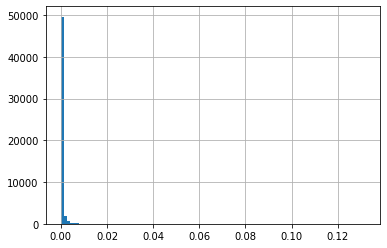

In [9]:
std_calc.hist(bins=100)

##This reveals that nearly 50k features have very weak variance, 
# and thereby unlikely to contain vital information for age prediction

In [ ]:
##feature selection: SelectKBest
# Selects the top 25% scoring features -- about 13k features 
k = int(X.shape[1] * 0.25)
selector = SelectKBest(mutual_info_regression, k = k)
selector.fit(X, y)

In [12]:
#generate the names of the remaining features 
kbest_support = X.columns[selector.get_support()]
kbest_support

Index(['ENSG00000000005.5', 'ENSG00000000419.12', 'ENSG00000000457.13',
       'ENSG00000000460.16', 'ENSG00000000938.12', 'ENSG00000000971.15',
       'ENSG00000001167.14', 'ENSG00000001460.17', 'ENSG00000001461.16',
       'ENSG00000001626.14',
       ...
       'ENSG00000283602.1', 'ENSG00000283607.1', 'ENSG00000283620.1',
       'ENSG00000283633.1', 'ENSG00000283647.1', 'ENSG00000283657.1',
       'ENSG00000283662.1', 'ENSG00000283683.1', 'ENSG00000283684.1',
       'ENSG00000283697.1'],
      dtype='object', length=13233)

In [13]:
##bivariate correlation between age and 25% percentile features
df_kbest_feats = df_feats_w_age_sample[kbest_support]
df_age = df_labels['age']

pairwise_corr = df_kbest_feats.corrwith(df_age, axis=0, drop=False, method='pearson')
pairwise_corr.describe()
pairwise_corr

##This reveals - to our dismay - that there's the no statistically significant 
# correlation between many features and age of the patient
# Though it allow us to further reduce the dimentionality of the features 
##This also rule out linear regression as a potential prediction method

ENSG00000000005.5    -0.111076
ENSG00000000419.12    0.176511
ENSG00000000457.13    0.213035
ENSG00000000460.16    0.180286
ENSG00000000938.12   -0.088191
                        ...   
ENSG00000283657.1     0.013041
ENSG00000283662.1     0.111308
ENSG00000283683.1    -0.036742
ENSG00000283684.1     0.019222
ENSG00000283697.1     0.185066
Length: 13233, dtype: float64

In [14]:
##removing features with less than +- 0.2 correlation with age
# This leaves us with 4 thousand features, which is manageable for some learning attempts
pairwise_corr_filtered = pairwise_corr.loc[abs(pairwise_corr) >= 0.2]
pairwise_corr_filtered

ENSG00000000457.13    0.213035
ENSG00000001461.16    0.221449
ENSG00000004059.10    0.209159
ENSG00000004142.11    0.204998
ENSG00000004478.7     0.250613
                        ...   
ENSG00000283377.1    -0.226683
ENSG00000283390.1     0.233593
ENSG00000283453.1     0.205079
ENSG00000283547.1    -0.201583
ENSG00000283620.1     0.225028
Length: 3873, dtype: float64

In [17]:
##persist the df (the remaining features)
# X_filtered = X[pairwise_corr_filtered.index]
# X_filtered.to_pickle('./X_filtered.pickle')

(965, 3873)


In [18]:
X_filtered = pd.read_pickle('./X_filtered.pickle')
print(X_filtered.shape)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

(965, 3873)


In [ ]:
##Performing a cartesian product correlation calculation
# The goal is to reveal features that may be strongly correlated with themselves
# and *may* allow us to reduce the features further
filtered_corr = X_filtered.corr(method='pearson')

In [46]:
##removing value 1.0 from the df, as they are the correlation with self
# which is just the diagonal line of the df
filtered_corr_rm_diag = filtered_corr.copy()
for i in range(len(filtered_corr)):
    filtered_corr_rm_diag.iloc[i,i] = None
    
filtered_corr_rm_diag

,ENSG00000000457.13,ENSG00000001461.16,ENSG00000004059.10,ENSG00000004142.11,ENSG00000004478.7,ENSG00000004779.9,ENSG00000004838.13,ENSG00000005022.5,ENSG00000005156.11,ENSG00000005175.9,...,ENSG00000283174.1,ENSG00000283220.1,ENSG00000283266.1,ENSG00000283368.1,ENSG00000283371.1,ENSG00000283377.1,ENSG00000283390.1,ENSG00000283453.1,ENSG00000283547.1,ENSG00000283620.1
ENSG00000000457.13,NaN,0.629971,0.586050,0.583838,0.560616,0.616913,0.548981,0.579765,0.684301,0.792684,...,-0.263991,0.701752,0.677614,-0.281305,0.757238,-0.371873,0.568959,0.626789,-0.256472,0.698049
ENSG00000001461.16,0.629971,NaN,0.427006,0.504683,0.566244,0.494109,0.436020,0.505156,0.586107,0.662638,...,-0.246419,0.493919,0.658826,-0.288485,0.617767,-0.361990,0.441263,0.619072,-0.248308,0.623120
ENSG00000004059.10,0.586050,0.427006,NaN,0.606935,0.550115,0.777183,0.521925,0.694310,0.515079,0.580500,...,-0.288018,0.685924,0.423980,-0.309645,0.551801,-0.374544,0.786922,0.581512,-0.311487,0.692398
ENSG00000004142.11,0.583838,0.504683,0.606935,NaN,0.641047,0.686901,0.398832,0.652106,0.627791,0.684452,...,-0.229287,0.620567,0.600116,-0.325126,0.533264,-0.340473,0.593315,0.586837,-0.259930,0.664424
ENSG00000004478.7,0.560616,0.566244,0.550115,0.641047,NaN,0.670017,0.506098,0.592668,0.598098,0.699216,...,-0.277383,0.596275,0.615966,-0.400211,0.580040,-0.398938,0.607747,0.606322,-0.307557,0.698339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000283377.1,-0.371873,-0.361990,-0.374544,-0.340473,-0.398938,-0.386857,-0.299730,-0.378911,-0.355282,-0.401772,...,0.247485,-0.378150,-0.388723,0.314276,-0.395259,NaN,-0.415054,-0.418771,0.630886,-0.405978
ENSG00000283390.1,0.568959,0.441263,0.786922,0.593315,0.607747,0.770991,0.610873,0.607880,0.503328,0.555824,...,-0.296566,0.700459,0.450727,-0.462987,0.590088,-0.415054,NaN,0.538731,-0.342924,0.684172
ENSG00000283453.1,0.626789,0.619072,0.581512,0.586837,0.606322,0.614263,0.351811,0.737292,0.649834,0.752840,...,-0.285854,0.537987,0.718616,-0.465573,0.606439,-0.418771,0.538731,NaN,-0.313098,0.693215
ENSG00000283547.1,-0.256472,-0.248308,-0.311487,-0.259930,-0.307557,-0.309210,-0.243198,-0.316987,-0.237279,-0.293809,...,0.142514,-0.295821,-0.241810,0.256793,-0.316983,0.630886,-0.342924,-0.313098,NaN,-0.332379


In [49]:
## We expect *many* clusters of inter-correlated features from this basic report
#  A way to mentally visualize them is to consider them as nodes of a graph, 
#  where an edge exist between two nodes when their correlation is > +- .8

## At this point we decide to attempt some learning models before further 
#  reducing the features. 
filtered_corr_rm_diag.describe()

,ENSG00000000457.13,ENSG00000001461.16,ENSG00000004059.10,ENSG00000004142.11,ENSG00000004478.7,ENSG00000004779.9,ENSG00000004838.13,ENSG00000005022.5,ENSG00000005156.11,ENSG00000005175.9,...,ENSG00000283174.1,ENSG00000283220.1,ENSG00000283266.1,ENSG00000283368.1,ENSG00000283371.1,ENSG00000283377.1,ENSG00000283390.1,ENSG00000283453.1,ENSG00000283547.1,ENSG00000283620.1
count,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,...,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000
mean,0.576812,0.517311,0.527440,0.530343,0.543048,0.574201,0.430386,0.559752,0.543411,0.633227,...,-0.238635,0.545385,0.582614,-0.329977,0.566535,-0.336732,0.529026,0.592333,-0.254621,0.606688
std,0.257546,0.241717,0.257728,0.226662,0.253036,0.254109,0.209325,0.255471,0.246183,0.283849,...,0.131958,0.249902,0.270936,0.213278,0.263056,0.200483,0.272322,0.284175,0.157614,0.273591
min,-0.560534,-0.528495,-0.603606,-0.529907,-0.589222,-0.603262,-0.454203,-0.627079,-0.520204,-0.607611,...,-0.365180,-0.573070,-0.583272,-0.560884,-0.563958,-0.492855,-0.634350,-0.644049,-0.390682,-0.630077
25%,0.574371,0.504684,0.490760,0.535937,0.556578,0.562742,0.405781,0.546048,0.541256,0.620449,...,-0.293444,0.546793,0.550540,-0.442130,0.562857,-0.416998,0.487960,0.566041,-0.322919,0.620703
50%,0.644522,0.583413,0.581472,0.591239,0.609528,0.636287,0.471776,0.627207,0.611870,0.713484,...,-0.271785,0.605190,0.652887,-0.372335,0.633403,-0.385397,0.580341,0.667707,-0.292696,0.677566
75%,0.695590,0.639317,0.664925,0.632033,0.651011,0.692572,0.535943,0.687162,0.659998,0.772725,...,-0.245761,0.655546,0.729494,-0.304121,0.688080,-0.352221,0.673149,0.742242,-0.257823,0.722886
max,0.854063,0.775522,0.886404,0.893947,0.970033,0.876643,0.858121,0.960791,0.789452,0.900455,...,0.774902,0.998809,0.964026,0.996901,0.856796,0.734694,0.895916,0.886999,0.631837,0.987916


In [51]:
filtered_corr_rm_diag.iloc[-1,:].describe()

count    3850.000000
mean        0.606688
std         0.273591
min        -0.630077
25%         0.620703
50%         0.677566
75%         0.722886
max         0.987916
Name: ENSG00000283620.1, dtype: float64

## Learning Model Training

In [20]:
##train: LinearRegression
# This is an attempt made after reducing features down to 14k
# Largely a mental milestone & an indicator of works needed ahead
reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))
print(reg.coef_)
print(reg.intercept_)


1.0
[ 3.43564063e+03  1.87563174e+03 -3.01708875e+03 ... -2.44663385e+00
 -5.27471495e+01  2.04459063e+02]
50.50887375385108


In [21]:
##test
y_pred = reg.predict(X_test)
r2_score(y_test, y_pred)

-21.405575387473107

In [27]:
##train: Neural Network
regr = MLPRegressor(random_state=1, max_iter=10000).fit(X_train, y_train)

In [28]:
regr.score(X_test, y_test)

0.13148537237414015

In [47]:
pred = regr.predict(X_test[:100]).round()
actual = y_test[:100].values * 1.
data = {'pred': pred, 'actual': actual}
df_predictions = pd.DataFrame(data=data)
df_predictions['error'] = abs(df_predictions['actual'] - df_predictions['pred'])
pd.set_option("display.max_rows", None)
print(df_predictions)

    pred  actual  error
0   53.0    34.0   19.0
1   52.0    51.0    1.0
2   45.0    34.0   11.0
3   56.0    54.0    2.0
4   54.0    64.0   10.0
5   48.0    54.0    6.0
6   46.0    64.0   18.0
7   61.0    54.0    7.0
8   52.0    44.0    8.0
9   56.0    59.0    3.0
10  59.0    64.0    5.0
11  59.0    79.0   20.0
12  39.0    36.0    3.0
13  73.0    50.0   23.0
14  65.0    75.0   10.0
15  50.0    65.0   15.0
16  45.0    46.0    1.0
17  64.0    54.0   10.0
18  58.0    64.0    6.0
19  66.0    47.0   19.0
20  41.0    79.0   38.0
21  41.0    54.0   13.0
22  59.0    54.0    5.0
23  46.0    54.0    8.0
24  51.0    54.0    3.0
25  50.0    54.0    4.0
26  44.0    54.0   10.0
27  58.0    64.0    6.0
28  63.0    58.0    5.0
29  54.0    44.0   10.0
30  68.0    89.0   21.0
31  52.0    58.0    6.0
32  55.0    44.0   11.0
33  48.0    49.0    1.0
34  44.0    41.0    3.0
35  51.0    65.0   14.0
36  45.0    44.0    1.0
37  81.0    78.0    3.0
38  44.0    54.0   10.0
39  54.0    54.0    0.0
40  57.0    54.0

In [48]:
## Keep this cell for reference

#  A more comprehensible representation of the NN's accuracy
#  Overall, better than initial expectation. We can predict a patient's age group with reasonable confidence 
#  This is encouraging, as the NN has potential to improve from further reduction, noise suppression, etc.
df_predictions.describe()

,pred,actual,error
count,100.000000,100.000000,100.000000
mean,53.670000,53.970000,9.820000
std,8.956748,13.710171,7.870646
min,27.000000,24.000000,0.000000
25%,48.000000,45.500000,3.000000
50%,53.000000,54.000000,8.000000
75%,59.000000,64.000000,14.250000
max,81.000000,89.000000,38.000000


In [59]:
##generate prediction csv
pd.set_option("display.max_rows", 10)

X_test_submission = df_norm_expression_test[X_filtered.columns]
age = regr.predict(X_test_submission)
sample_id = df_labels_test['sample_id']
data = {'age': age, 'sample_id': sample_id}
df_submission = pd.DataFrame(data=data)
print(df_submission)
df_submission.to_csv()

           age sample_id
0    44.420779  12fa2c69
1    39.257745  4d41ce5f
2    49.720087  82f6b2bb
3    74.820604  81161a04
4    54.156962  4370df33
..         ...       ...
960  47.126699  f71936c8
961  66.588018  063448fa
962  42.200743  3dd9a2df
963  49.426143  70120a3f
964  58.968740  b9df2325

[965 rows x 2 columns]


,ENSG00000000457.13,ENSG00000001461.16,ENSG00000004059.10,ENSG00000004142.11,ENSG00000004478.7,ENSG00000004779.9,ENSG00000004838.13,ENSG00000005022.5,ENSG00000005156.11,ENSG00000005175.9,...,ENSG00000283174.1,ENSG00000283220.1,ENSG00000283266.1,ENSG00000283368.1,ENSG00000283371.1,ENSG00000283377.1,ENSG00000283390.1,ENSG00000283453.1,ENSG00000283547.1,ENSG00000283620.1
0,169431,132119,523352,385926,345701,145351,6734,591673,237900,134419,...,164,186077,38914,8471,278,513,14930,439,226,25962
1,112703,150374,302003,657986,1601669,144474,27291,997718,165433,123939,...,26,268067,129624,4712,935,79,33859,3370,7,43806
2,174936,163311,735528,617705,524731,247892,13446,1093897,205684,107447,...,78,212398,37549,16338,451,0,23389,76,79,37530
3,444488,498159,1008124,937631,3722663,452446,110601,2036867,677473,379619,...,53,640312,498090,8611,6439,93,114777,7585,15,77472
4,134343,77754,509488,440605,442941,186591,6751,976935,194812,95837,...,413,152887,25711,4898,702,333,19045,371,173,25528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,108992,82727,324280,313391,99210,121089,1915,406675,112263,86295,...,190,65583,38661,3618,153,997,6750,137,220,9746
961,228193,205351,826366,885484,4282884,453601,44254,2296528,335082,264064,...,0,344795,163338,939,2133,0,99742,7099,92,69688
962,91054,103814,467768,582218,180803,237405,3170,785323,124564,79077,...,159,166952,35428,4961,153,894,16774,77,390,17952
963,663404,296357,1078914,522096,2113110,374071,7914,1759944,345096,284661,...,95,365462,217859,7134,1322,430,73468,33253,0,75833


In [ ]:
Rough plans ahead:
    Improve NN performance
        1. Reduce features
        2. Consider train data noise
        3. configure the NN
    idk, we prob dont have a whole lot of choices other than NN

## Scratch notes

In [ ]:
##write a batch code to run analysis to all features & generate report 
    ##basic singlevariate indicators: describe(), etc.
    ##bivariate stuff: correlation coeff, & more?
##no visualization yet for we are just coming up with suitable criteria to narrow down features
##criteria to eliminate insequential columns
    ##extremely weak pearsons' correlation coeff can eliminate

##further narrow features w/ feature selection algo?

##data preprocessing: some features have weird distribution, may need to remove noise
    ##not sure how grouping of the patients come into play, may need analysis separately
##neural network
##PROFIT
